# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Hongjie Xu
#### Student ID: s3880497

Date: 02/10/2021

Version: 1.0

Environment: Python 3 and Jupyter Notebook

Libraries used: 
* pandas
* re
* numpy
* sklearn
* itertools
* matplotlib
* gemsim
* scipy
* nltk

## Introduction

To do job classification, it is necessary to find an appropriate vector representation to represent the document. The document representation vector can be generate from word vector. In this assignment, **Count Vector** & Several **Pre-trained** vector are tested. 

This notebook has two parts:

1. First Part include:
    * Generate several word vectors
    * Generate corresponding document vectors, such as **Count Vector**, **FastText**, **Word2Vec**
    * Plot those high dimension document vectors to 2 dimension
    * Using LogisticRegression to train the classification model, comparing the performance among seven different doc_vectors
2. Second Part include:
    * Creating title only doc vector
    * Jointly training emebedding vector for title and description
    * Seperately training emebedding vector for title and description
    
In the end, I will summarise the general conclusion based on the above experiments.

## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment, e.g.,
import os
import pandas as pd
import numpy as np
import logging
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from scipy import sparse
import gensim.downloader as api
import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer

# Tracking events and display information through Logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

### Bag-of-words model - Count Vector

In [2]:
# read vocabulary file from task1
vocabulary=[]
with open('vocab.txt') as f:
    lines = f.read().splitlines()
    for line in lines:
        vocabulary.append(line[0:line.find(':')])

In [6]:
# read description document into a list

description=[]
webindex=[]
category=[]
title=[]
with open('job_ads.txt') as f:
    lines = f.read().splitlines()
    for line in lines:
        if line.startswith('Description:'):
            description.append(line[line.find(': ') + 2:])
        if line.startswith('Webindex:'):
            webindex.append(line[line.find(': ')+2:])
        if line.startswith('Category:'):
            category.append(line[line.find(': ')+2:])
        if line.startswith('Title:'):
            title.append(line[line.find(': ')+2:])

In [7]:
# Split joint tokens into single token

description_tokenized=[]
for job in description:
    description_tokenized.append(job.split())

In [9]:
# Countvector

cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocabulary)
# generate the count vector representation for all articles
count_features = cVectorizer.fit_transform([' '.join(job_description) for job_description in description_tokenized])
# check up the shape of count_vector
print(count_features.shape)

(55449, 40038)


In [10]:
# Create the nonzero count vector from count_features acquired above, will be used to output count_vectors.txt

count_doc_vector=[]
for job_idx in range(0, len(webindex)):
    vocab_count_dict={}
    for i in count_features[job_idx].toarray().reshape(-1).nonzero()[0]:
        vocab_count_dict[i]=count_features[job_idx].toarray()[:,i][0]
    count_doc_vector.append(vocab_count_dict)

KeyboardInterrupt: 

### Functions Generating Document Vector

In [8]:
# Define a function to generate document vector

def generate_doc_vector(tokenized_doc_list, word_vector, tfidf_features, tfidf_vocab, tfidf_weighted=True):
    ''' 
    parameters:
            tokenized_doc_list:   tokenized sentence list     LIST
            tfidf_features:       TF-IDF feature              sparse matrix
            tfidf_vocab:          TF-IDF vocab                vocab dict
            word_vector:          word vector                 word_vector object
            tfidf_weighted:       default True                BOOL
    return:
            doc_matrix.T          document vector             numpy array shape(number of document ,vector_dimension)                           
    
    '''
    doc_num=len(tokenized_doc_list)
    wv_dimension=word_vector.vector_size
    doc_matrix=np.zeros((wv_dimension, doc_num))
    
    for sen_idx in range(0,doc_num):
        if tfidf_weighted:
            tokens = list(set(tokenized_doc_list[sen_idx]))
            sentence_matrix =np.zeros((wv_dimension, len(tokens)))
            for w_idx in range(0, len(tokens)):
                try:
                    word=tokens[w_idx]
                    word_vec=word_vector[word]
                    word_vec_weighted = word_vec * tfidf_features[sen_idx].toarray()[:, tfidf_vocab[word]]
                    sentence_matrix[:,w_idx]=word_vec_weighted
                except:
                    pass
            
        else:
            sentence_matrix =np.zeros((wv_dimension, len(tokenized_doc_list[sen_idx])))
            for w_idx in range(0, len(tokenized_doc_list[sen_idx])):
                try:
                    word=tokenized_doc_list[sen_idx][w_idx]
                    word_vec=word_vector[word]
                    sentence_matrix[:,w_idx]=word_vec
                except:
                    pass
        doc_matrix[:,sen_idx]=sentence_matrix.sum(axis=1)
    return doc_matrix.T


In [9]:
# Description Document tfidf weight acquired

description_tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = set(vocabulary)) # initialised the TfidfVectorizer
des_tfidf_features = description_tVectorizer.fit_transform([' '.join(article) for article in description_tokenized]) # generate the tfidf vector representation for all articles
des_tfidf_features.shape
des_tfidf_features_vocab = description_tVectorizer.vocabulary_

### FastText

In [10]:
# initialise the fast text model
job_FT = FastText(vector_size=200)
# build the vocabulary
job_FT.build_vocab(description_tokenized)
# train the model
job_FT.train(description_tokenized, epochs=job_FT.epochs,
    total_examples=job_FT.corpus_count, total_words=job_FT.corpus_total_words,
)

print(job_FT)

2021-10-21 22:01:15,686 : INFO : FastText lifecycle event {'params': 'FastText(vocab=0, vector_size=200, alpha=0.025)', 'datetime': '2021-10-21T22:01:15.686991', 'gensim': '4.1.2', 'python': '3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-10-21 22:01:15,690 : INFO : collecting all words and their counts
2021-10-21 22:01:15,691 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-10-21 22:01:16,002 : INFO : PROGRESS: at sentence #10000, processed 1132872 words, keeping 26067 word types
2021-10-21 22:01:16,292 : INFO : PROGRESS: at sentence #20000, processed 2254158 words, keeping 32732 word types
2021-10-21 22:01:16,586 : INFO : PROGRESS: at sentence #30000, processed 3369213 words, keeping 36403 word types
2021-10-21 22:01:16,887 : INFO : PROGRESS: at sentence #40000, processed 4506763 words, keeping 38518 word types
2021-10-21 22:01:17,178 : INFO : PROGRESS: at sentence #

2021-10-21 22:02:11,956 : INFO : EPOCH 1 - PROGRESS: at 70.75% examples, 90581 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:02:12,968 : INFO : EPOCH 1 - PROGRESS: at 72.14% examples, 90500 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:02:14,063 : INFO : EPOCH 1 - PROGRESS: at 73.42% examples, 90077 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:02:15,219 : INFO : EPOCH 1 - PROGRESS: at 75.01% examples, 89940 words/s, in_qsize 6, out_qsize 1
2021-10-21 22:02:16,333 : INFO : EPOCH 1 - PROGRESS: at 76.76% examples, 90073 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:02:17,336 : INFO : EPOCH 1 - PROGRESS: at 78.52% examples, 90393 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:02:18,517 : INFO : EPOCH 1 - PROGRESS: at 80.12% examples, 90211 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:02:19,525 : INFO : EPOCH 1 - PROGRESS: at 81.54% examples, 90149 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:02:20,699 : INFO : EPOCH 1 - PROGRESS: at 83.49% examples, 90344 words/s, in_qsize 5, out_

2021-10-21 22:03:28,368 : INFO : EPOCH 2 - PROGRESS: at 94.83% examples, 100859 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:03:29,430 : INFO : EPOCH 2 - PROGRESS: at 96.82% examples, 101032 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:03:30,484 : INFO : EPOCH 2 - PROGRESS: at 98.55% examples, 101044 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:03:31,261 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-10-21 22:03:31,294 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-10-21 22:03:31,362 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-10-21 22:03:31,363 : INFO : EPOCH - 2 : training on 6239169 raw words (6127058 effective words) took 60.6s, 101116 effective words/s
2021-10-21 22:03:32,479 : INFO : EPOCH 3 - PROGRESS: at 1.59% examples, 88182 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:03:33,581 : INFO : EPOCH 3 - PROGRESS: at 3.47% examples, 96925 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:03:34,607 : IN

2021-10-21 22:04:40,340 : INFO : EPOCH 4 - PROGRESS: at 20.96% examples, 127897 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:04:41,438 : INFO : EPOCH 4 - PROGRESS: at 23.37% examples, 128399 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:04:42,550 : INFO : EPOCH 4 - PROGRESS: at 25.79% examples, 128662 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:04:43,553 : INFO : EPOCH 4 - PROGRESS: at 28.04% examples, 129240 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:04:44,571 : INFO : EPOCH 4 - PROGRESS: at 30.25% examples, 129570 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:04:45,613 : INFO : EPOCH 4 - PROGRESS: at 32.27% examples, 129007 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:04:46,757 : INFO : EPOCH 4 - PROGRESS: at 34.67% examples, 128945 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:04:47,889 : INFO : EPOCH 4 - PROGRESS: at 37.08% examples, 128939 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:04:49,058 : INFO : EPOCH 4 - PROGRESS: at 39.45% examples, 128689 words/s, in_qsiz

2021-10-21 22:05:55,870 : INFO : EPOCH 5 - PROGRESS: at 57.82% examples, 97292 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:05:56,930 : INFO : EPOCH 5 - PROGRESS: at 60.25% examples, 98448 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:05:58,002 : INFO : EPOCH 5 - PROGRESS: at 62.27% examples, 98999 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:05:59,004 : INFO : EPOCH 5 - PROGRESS: at 64.16% examples, 99446 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:06:00,140 : INFO : EPOCH 5 - PROGRESS: at 66.54% examples, 100271 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:06:01,264 : INFO : EPOCH 5 - PROGRESS: at 68.89% examples, 101065 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:06:02,391 : INFO : EPOCH 5 - PROGRESS: at 71.22% examples, 101819 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:06:03,504 : INFO : EPOCH 5 - PROGRESS: at 73.58% examples, 102565 words/s, in_qsize 5, out_qsize 0
2021-10-21 22:06:04,551 : INFO : EPOCH 5 - PROGRESS: at 75.96% examples, 103418 words/s, in_qsize 5,

FastText(vocab=22816, vector_size=200, alpha=0.025)


In [24]:
job_FT_wv = job_FT.wv

In [56]:
job_FT.save('./job_ft.model')

2021-10-22 10:35:26,524 : INFO : FastText lifecycle event {'fname_or_handle': './job_ft.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-10-22T10:35:26.524097', 'gensim': '4.1.2', 'python': '3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
2021-10-22 10:35:26,525 : INFO : storing np array 'vectors_ngrams' to ./job_ft.model.wv.vectors_ngrams.npy
2021-10-22 10:35:32,479 : INFO : not storing attribute buckets_word
2021-10-22 10:35:32,481 : INFO : not storing attribute vectors
2021-10-22 10:35:32,787 : INFO : saved ./job_ft.model


In [58]:
job_FT.wv == temp.wv

False

In [57]:
from gensim.models import Word2Vec
temp = FastText.load('job_ft.model')

2021-10-22 10:49:07,761 : INFO : loading FastText object from job_ft.model
2021-10-22 10:49:07,884 : INFO : loading wv recursively from job_ft.model.wv.* with mmap=None
2021-10-22 10:49:07,885 : INFO : loading vectors_ngrams from job_ft.model.wv.vectors_ngrams.npy with mmap=None
2021-10-22 10:49:16,636 : INFO : setting ignored attribute buckets_word to None
2021-10-22 10:49:16,637 : INFO : setting ignored attribute vectors to None
2021-10-22 10:49:18,862 : INFO : FastText lifecycle event {'fname': 'job_ft.model', 'datetime': '2021-10-22T10:49:18.862641', 'gensim': '4.1.2', 'python': '3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}


In [59]:
temp.wv['job']

array([ 0.82741743,  0.05047165, -1.7421659 , -0.97023326,  0.35085416,
       -0.5671077 , -0.3420759 , -0.24487077, -0.5347275 ,  1.8365707 ,
       -0.41797403,  1.0164593 , -0.24687904,  0.27159193, -2.3164508 ,
        0.28630504,  1.136887  , -0.832355  , -1.735484  , -0.927866  ,
       -0.35799888, -1.1623237 ,  0.95683223,  0.77473706, -1.141848  ,
        2.1508949 ,  0.16943103,  0.11702502,  1.5182976 ,  1.2583241 ,
       -1.3396429 ,  1.6372528 ,  1.047542  , -0.8838515 ,  1.1177415 ,
       -0.19346035,  0.618275  , -0.6861562 , -0.7296672 ,  1.722788  ,
       -1.06823   ,  1.4619645 , -1.4776907 ,  0.12475993,  0.4411638 ,
       -0.7868631 , -0.3226067 , -1.4022142 , -0.6544797 ,  1.5836692 ,
       -1.1718215 ,  1.4761335 ,  1.108425  ,  2.378069  , -0.79535097,
        0.8147426 ,  0.5236443 ,  0.12559734, -1.2870969 ,  2.3381052 ,
       -0.1287195 ,  1.2617054 , -0.47212407, -1.4959183 , -1.7783829 ,
        3.1262207 , -0.32018694,  4.680939  , -0.91849655, -0.33

##### Unweighted

In [15]:
# generate unweighted fasttext doc vector

unweighted_ft_doc_vector = generate_doc_vector(description_tokenized, job_FT_wv, des_tfidf_features, 
                                               des_tfidf_features_vocab, tfidf_weighted=False)
unweighted_ft_doc_vector

array([[ 49.47338967, -42.78937297,  28.19961535, ...,  -4.6995493 ,
        -12.30169984, -29.04956077],
       [-13.78098812,  18.13689221,  12.48977428, ...,   8.0848862 ,
        -20.36405687, -17.76607238],
       [ -7.72103254, -26.05820452, -19.31295759, ...,  21.16296623,
        -28.26495181,  21.60552386],
       ...,
       [ 87.14299571, -38.75013971,  -4.18488739, ..., -53.16977165,
        -46.90481094, -78.74387286],
       [ 13.57495312,  -3.328383  ,   2.72218267, ..., -15.30061069,
        -20.63550597, -17.14302609],
       [-23.82020912, -22.36789804, -12.84902138, ...,  20.3438464 ,
        -42.09053859, -10.80947056]])

In [16]:
unweighted_ft_doc_vector.shape

(55449, 200)

##### TF-IDF Weighted

In [13]:
# generate TF-IDF weighted fasttext doc vector

tfidfweighted_ft_doc_vector = generate_doc_vector(description_tokenized, job_FT_wv, des_tfidf_features, 
                                                  des_tfidf_features_vocab, tfidf_weighted=True)
tfidfweighted_ft_doc_vector

array([[ 6.06619593, -1.48072662,  4.75661684, ...,  0.13580139,
        -0.87060451, -0.48894188],
       [-1.37352818,  2.08211836,  1.78340729, ...,  1.47621665,
        -2.59406427, -1.50569354],
       [ 0.27246879, -3.93816692,  0.75388887, ...,  1.59189425,
        -2.22734206,  1.03808324],
       ...,
       [ 4.42495537, -2.19504692,  0.00691867, ..., -0.99303509,
        -2.73221595, -3.46211861],
       [ 3.09353365, -0.76314502, -0.01496161, ..., -0.42058404,
        -3.57433852, -0.21043305],
       [-2.83057963, -2.60818633, -0.6357542 , ...,  2.77618781,
        -5.61670765, -2.78320244]])

In [14]:
tfidfweighted_ft_doc_vector.shape

(55449, 200)

### Word2Vec - word2vec-google-news-300

In [7]:
# load pretrained wordvec google news 300
preTW2v_google_300_wv = api.load('word2vec-google-news-300')

2021-10-03 22:11:00,223 : INFO : loading projection weights from C:\Users\Hongjie Xu/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
2021-10-03 22:11:57,881 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from C:\\Users\\Hongjie Xu/gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-10-03T22:11:57.880860', 'gensim': '4.1.2', 'python': '3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}


##### Unweighted

In [18]:
# generate unweighted doc vector, from word2vec-google-news-300

unweighted_google_300_doc_vector = generate_doc_vector(description_tokenized, preTW2v_google_300_wv, des_tfidf_features, 
                                               des_tfidf_features_vocab,tfidf_weighted=False)
unweighted_google_300_doc_vector

array([[-4.54676819e+00,  5.06792450e+00,  2.48180008e+00, ...,
        -3.64318848e-01,  4.09868622e+00, -3.40421677e+00],
       [-8.72100830e-01,  5.57504654e-01, -4.74548340e-01, ...,
        -1.99374390e+00,  1.26920319e+00, -9.62341309e-01],
       [-3.47837830e+00,  1.44274139e+00, -1.09777832e+00, ...,
        -1.61264038e+00,  5.62152863e-01, -2.28509521e+00],
       ...,
       [-1.94825745e+00,  3.65135193e+00, -9.31793213e-01, ...,
         2.11063385e+00, -1.24869537e+00, -5.21130371e+00],
       [-1.16427612e+00,  1.45178223e+00, -1.22341919e+00, ...,
        -3.77188110e+00, -2.06726837e+00, -8.74908447e-01],
       [-2.63548279e+00,  1.35803223e-03,  1.21622086e-01, ...,
        -2.81733704e+00,  1.12408447e+00, -4.25326538e+00]])

In [19]:
unweighted_google_300_doc_vector.shape

(55449, 300)

##### TF-IDF Weighted

In [20]:
# generate TF-IDF weighted doc vector, from word2vec-google-news-300

tfidfweighted_google_300_doc_vector = generate_doc_vector(description_tokenized, preTW2v_google_300_wv, des_tfidf_features, 
                                               des_tfidf_features_vocab, tfidf_weighted=True)

tfidfweighted_google_300_doc_vector

array([[-0.30203168,  0.52696092,  0.31519145, ...,  0.02821987,
         0.5049506 , -0.12803456],
       [-0.00324751, -0.0035754 ,  0.07357384, ..., -0.1833097 ,
         0.00633404, -0.07155288],
       [-0.33508182,  0.07604858, -0.05317508, ..., -0.26194656,
         0.06828542, -0.23966359],
       ...,
       [-0.12370827,  0.40107306, -0.04235785, ...,  0.20707908,
         0.07791188, -0.11054661],
       [-0.13354128,  0.15667735, -0.16713934, ..., -0.58436352,
        -0.30779161, -0.11741237],
       [-0.26417546, -0.06760979, -0.07252548, ..., -0.31766894,
         0.07658425, -0.39805329]])

In [21]:
tfidfweighted_google_300_doc_vector.shape

(55449, 300)

### Word2Vec glove-twitter-100

In [20]:
# load pretrained twitter-100 word vector

preTW2v_twitter100_wv = api.load('glove-twitter-100')

2021-10-03 19:56:13,933 : INFO : loading projection weights from C:\Users\Hongjie Xu/gensim-data\glove-twitter-100\glove-twitter-100.gz
2021-10-03 19:58:50,855 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (1193514, 100) matrix of type float32 from C:\\Users\\Hongjie Xu/gensim-data\\glove-twitter-100\\glove-twitter-100.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2021-10-03T19:58:50.855625', 'gensim': '4.1.2', 'python': '3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}


##### Unweighted

In [21]:
# generate unweighted doc vector, from Word2Vec glove-twitter-100

unweighted_twitter_100_doc_vector = generate_doc_vector(description_tokenized, preTW2v_twitter100_wv, des_tfidf_features, 
                                               des_tfidf_features_vocab, tfidf_weighted=False)

unweighted_twitter_100_doc_vector

array([[  6.22764912,  -6.77676251,  -0.21305829, ...,  -6.45887233,
         -3.44292233,   9.63301506],
       [  6.74126903,   3.34729883,  -3.678642  , ...,  -0.22194001,
          4.27533692,   0.24353684],
       [  2.13664117,  -1.64559897,  -1.74119586, ...,  -1.89864465,
         -7.57133866,  -2.30135185],
       ...,
       [  4.47878275,  -9.20646626,  -4.86894339, ...,   3.50328089,
         -0.715385  , -13.01396549],
       [  2.87659298,   1.65488884,  -2.28921906, ...,  -3.25181194,
         -1.99381738,  -2.24486003],
       [  6.55845794,  10.9136    ,  -3.19699625, ...,   1.68494006,
          0.62205176,  -6.91880362]])

In [22]:
unweighted_twitter_100_doc_vector.shape

(55449, 100)

##### TF-IDF Weighted

In [23]:
# generate TF-IDF weighted doc vector, from Word2Vec glove-twitter-100

tfidfweighted_twitter_100_doc_vector = generate_doc_vector(description_tokenized, preTW2v_twitter100_wv, des_tfidf_features, 
                                               des_tfidf_features_vocab, tfidf_weighted=True)

tfidfweighted_twitter_100_doc_vector

array([[ 0.19137519, -0.45836163, -0.08768882, ..., -0.46830562,
        -0.60108331,  1.30727664],
       [ 0.63084628,  0.35642904, -0.09132556, ...,  0.06411135,
         0.28374468,  0.28297356],
       [ 0.17421155, -0.3304108 , -0.10117896, ..., -0.250733  ,
        -1.00758451,  0.02320385],
       ...,
       [ 0.12055196, -0.91717288, -0.39320004, ...,  0.12724413,
        -0.10084684, -0.37511853],
       [ 0.08215962,  0.1810785 , -0.2608888 , ..., -0.39345739,
        -0.33278109,  0.05396138],
       [ 0.52356895,  1.12649743, -0.15609971, ...,  0.14209038,
        -0.15395544, -0.43881248]])

In [24]:
tfidfweighted_twitter_100_doc_vector.shape

(55449, 100)

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [17]:
with open('./count_vectors.txt', 'w') as f:
    for doc_idx in range(0,len(webindex)):
        f.write('#'+webindex[doc_idx]+',')
        for idx, count in count_doc_vector[doc_idx].items():
            f.write(str(idx)+':'+str(count)+',')
        f.write('\n')

## Task 3. Job Advertisement Classification

### Q1. Langugage model comparsions

For now, 7 document vectors are acquired,  

- `count_doc_vector`
- `unweighted_ft_doc_vector`
- `tfidfweighted_ft_doc_vector`
- `unweighted_google_300_doc_vector` 
- `tfidfweighted_google_300_doc_vector`
- `unweighted_twitter_100_doc_vector`
- `tfidfweighted_twitter_100_doc_vector`

First of all, we can plot these doc vectors to a 2 dimension projection, using tSNE method. Let's see how the different jobs are separated.

Then, models can be trained using these vectors, the performance can be compared.

#### Visualization by tSNE

In [18]:
# new variable from category

label = np.array(category)

In [27]:
# Create doc vector list

doc_vector_list = {"Count Vector": count_features,
                   "Unweighted FastText Vector": unweighted_ft_doc_vector, 
                   "TF-IDF Weighted FastText Vector": tfidfweighted_ft_doc_vector,
                   "Unweighted Google 300 Vector": unweighted_google_300_doc_vector,
                   "TF-IDF Weighted Google 300 Vector": tfidfweighted_google_300_doc_vector,
                   "Unweighted Twitter 100 Vector": unweighted_twitter_100_doc_vector,
                   "TF-IDF Weighted Twitter 100 Vector": tfidfweighted_twitter_100_doc_vector}

In [28]:
# Ploting tSNE, 2 dimension projection

def plot_tSNE(labels, features, sample_ratio, vec_name):
    categories = sorted(np.unique(label))
    
    sample_size = int(features.shape[0] * sample_ratio)
    
    np.random.seed(0)
    indices = np.random.choice(range(features.shape[0]), size=sample_size, replace=False)
    projected_features = TSNE(n_components=2, random_state=0, init='random', 
                              learning_rate='auto').fit_transform(features[indices])
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'wheat']
    plt.figure(figsize=(10, 8))
    for i in range(0, len(categories)):
        points = projected_features[(labels[indices]==categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector(" + vec_name + ") projection for job categories, using tSNE method")
    plt.legend()
    plt.show()
    

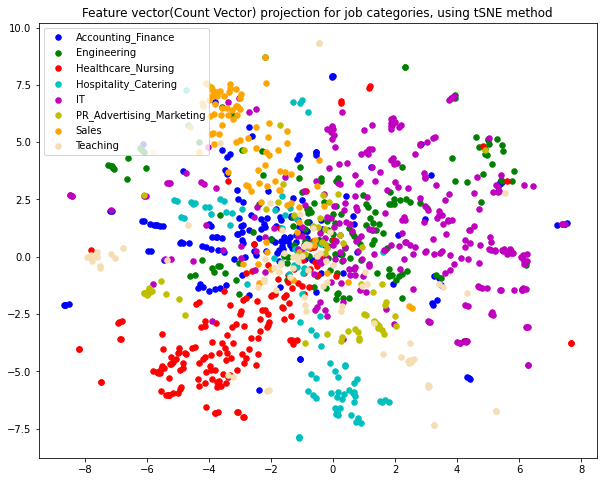

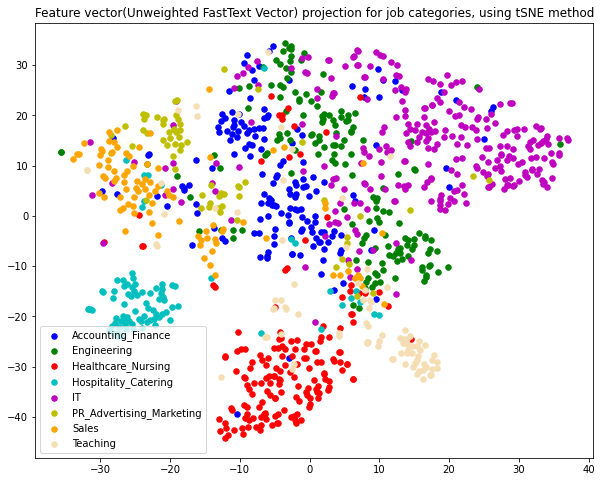

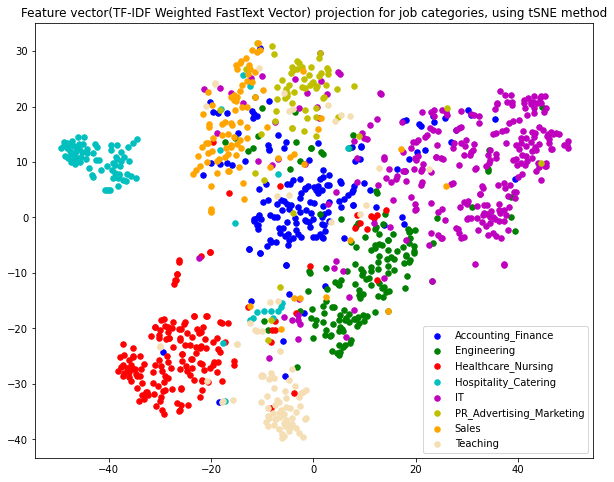

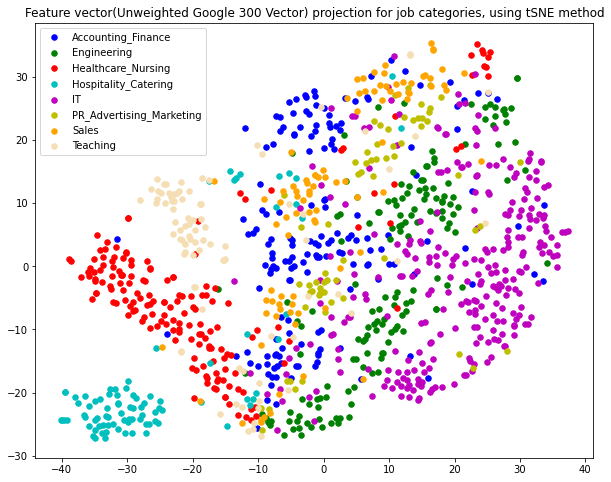

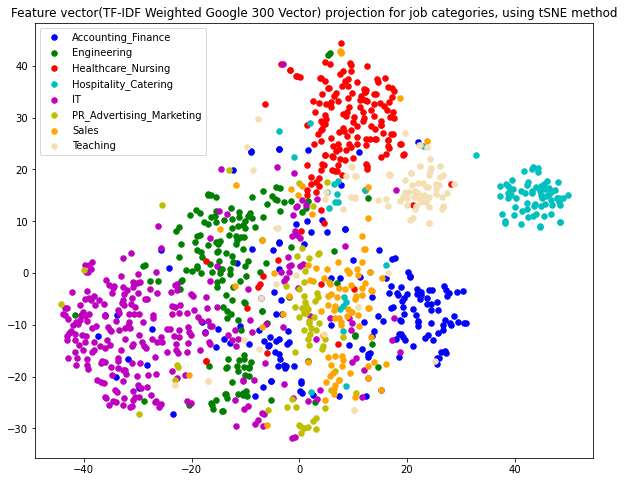

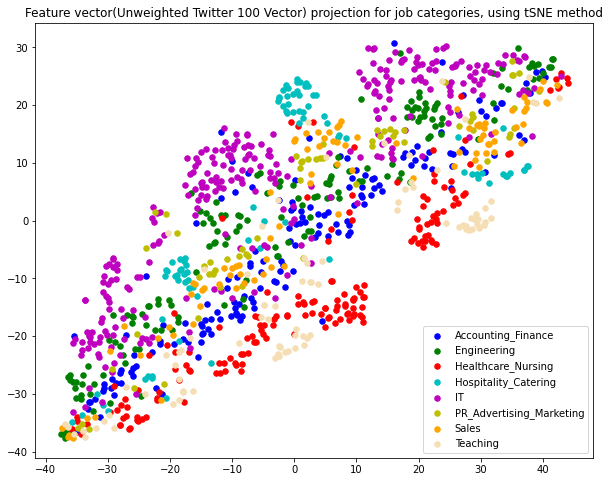

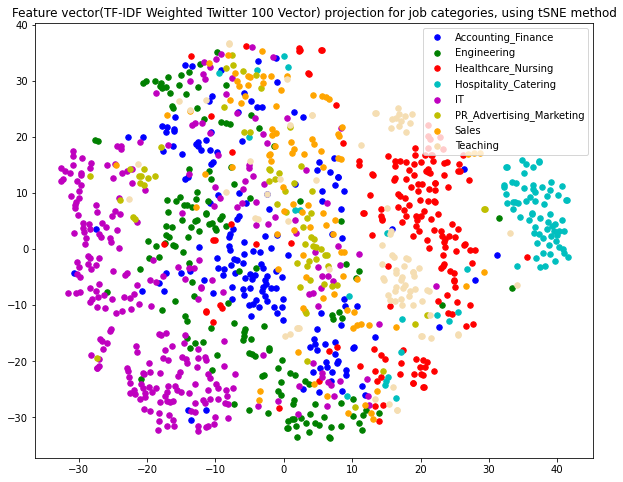

In [29]:
# Using 7 features to generate tSNE feature vector projection

for key,doc_vec in doc_vector_list.items():
    plot_tSNE(label, doc_vec, 0.02, key)

#### Classification Model

Logistic Regression model is selected as classfication method in this task, given max_iter with 3000.

Note that 5-folds cross validation is applied in this model training to compare performance between different feature representations. 

In [19]:
# Create a classification model

model = LogisticRegression(max_iter = 3000,random_state=2)

In [22]:
model = LogisticRegression(max_iter = 3000, random_state=2)
model.fit(unweighted_ft_doc_vector, label)

import pickle
pkl_filename = "job_LR.pkl"
with open(pkl_filename, 'wb') as file:
     pickle.dump(model, file)

C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [31]:
# create csr_matrix for count vector

count_features = sparse.csr_matrix(count_features)

In [32]:
# Training all models with different feature representations

# count vector
count_cv_result = cross_val_score(model, count_features, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using Count vector training finished, Average Accuray is ' + str(count_cv_result.mean()))

# unweighted FastText 
unw_ft_cv_result = cross_val_score(model, unweighted_ft_doc_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using Unweighted FastText training finished, Average Accuray is ' + str(unw_ft_cv_result.mean()))

# TF-IDF weigghted FastText
w_ft_cv_result = cross_val_score(model, tfidfweighted_ft_doc_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using TF-IDF Weighted FastText training finished, Average Accuray is ' + str(w_ft_cv_result.mean()))

# unweighted google 300 
unw_google_cv_result = cross_val_score(model, unweighted_google_300_doc_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using Unweighted Google-300 training finished, Average Accuray is ' + str(unw_google_cv_result.mean()))

# TF-IDF weighted google 300
w_google_cv_result = cross_val_score(model, tfidfweighted_google_300_doc_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using TF-IDF Weighted Google-300 training finished, Average Accuray is ' + str(w_google_cv_result.mean()))

# unweighted twitter 100 
unw_twitter_cv_result = cross_val_score(model, unweighted_twitter_100_doc_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using Unweighted Twitter-100 training finished, Average Accuray is ' + str(unw_twitter_cv_result.mean()))

# TF-IDF weighted twitter 100
w_twitter_cv_result = cross_val_score(model, tfidfweighted_twitter_100_doc_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using TF-IDF Weighted Twitter-100 training finished, Average Accuray is ' + str(w_twitter_cv_result.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time= 1.0min
------------------------------------------------------------------------------------------------------
Model using Count vector training finished, Average Accuray is 0.8736676798370688


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] END .................................................... total time= 1.7min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 1.7min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 1.8min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 1.7min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.7min
------------------------------------------------------------------------------------------------------
Model using Unweighted FastText training finished, Average Accuray is 0.8678065127782828
[CV] END .................................................... total time=  52.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.2s remaining:    0.0s


[CV] END .................................................... total time=  50.7s
[CV] END .................................................... total time=  50.8s
[CV] END .................................................... total time=  53.1s
[CV] END .................................................... total time=  48.8s
------------------------------------------------------------------------------------------------------
Model using TF-IDF Weighted FastText training finished, Average Accuray is 0.8732168573622012


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time= 1.2min
[CV] END .................................................... total time= 1.2min
------------------------------------------------------------------------------------------------------
Model using Unweighted Google-300 training finished, Average Accuray is 0.85996143994719


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  24.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s


[CV] END .................................................... total time=  23.0s
[CV] END .................................................... total time=  25.1s
[CV] END .................................................... total time=  26.6s
[CV] END .................................................... total time=  25.5s
------------------------------------------------------------------------------------------------------
Model using TF-IDF Weighted Google-300 training finished, Average Accuray is 0.8651013225968007


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] END .................................................... total time= 1.6min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 1.6min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 1.5min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 1.5min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.5min
------------------------------------------------------------------------------------------------------
Model using Unweighted Twitter-100 training finished, Average Accuray is 0.8380674599260465
[CV] END .................................................... total time=  28.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s remaining:    0.0s


[CV] END .................................................... total time=  25.9s
[CV] END .................................................... total time=  26.5s
[CV] END .................................................... total time=  28.1s
[CV] END .................................................... total time=  27.0s
------------------------------------------------------------------------------------------------------
Model using TF-IDF Weighted Twitter-100 training finished, Average Accuray is 0.8357951034912947


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


In [33]:
print('Model using Count vector training finished, Average Accuray is ' + str(count_cv_result.mean()))
print('Model using Unweighted FastText training finished, Average Accuray is ' + str(unw_ft_cv_result.mean()))
print('Model using TF-IDF Weighted FastText finished, Average Accuray is ' + str(w_ft_cv_result.mean()))
print('Model using Unweighted Google-300 training finished, Average Accuray is ' + str(unw_google_cv_result.mean()))
print('Model using TF-IDF Weighted Google-300 finished, Average Accuray is ' + str(w_google_cv_result.mean()))
print('Model using Unweighted Twitter-100 training finished, Average Accuray is ' + str(unw_twitter_cv_result.mean()))
print('Model using TF-IDF Weighted Twitter-100 finished, Average Accuray is ' + str(w_twitter_cv_result.mean()))

Model using Count vector training finished, Average Accuray is 0.8736676798370688
Model using Unweighted FastText training finished, Average Accuray is 0.8678065127782828
Model using TF-IDF Weighted FastText finished, Average Accuray is 0.8732168573622012
Model using Unweighted Google-300 training finished, Average Accuray is 0.85996143994719
Model using TF-IDF Weighted Google-300 finished, Average Accuray is 0.8651013225968007
Model using Unweighted Twitter-100 training finished, Average Accuray is 0.8380674599260465
Model using TF-IDF Weighted Twitter-100 finished, Average Accuray is 0.8357951034912947


##### Q1 Experiment Results
| Feature vector | Cross-valid Accuracy Rate |
|---|---|
| **Count vector** | **87.3667%** |
| Unweighted FastText | 86.7807% |
| **TF-IDF Weighted** | **87.3216%** |
| Unweighted Google-300 | 85.9961% |
| TF-IDF Weighted Google-300 | 86.5101% |
| Unweighted Twitter-100 | 83.8067% |
| TF-IDF Weighted Twitter-100 | 83.5777% |

**Count Vector** & **TF-IDF Weighted** both achieve similar highest performance on classification model.

Wordvec Twitter pre-trained word vector does not perform well, compared with others.

### Q2. Langugage model comparsions

Research Question

To answer the research question in Q2,

The following experiments are designed. We need to acquire three different document vector to test how they contribute to the model performance. 

- Title Only
- Description Only (Done in Q1)
- Title & Description together

However, it is interesting to discuss how to train the document vector from title and description together. 
We have two strategies,
1. Training them seperately, then merge them as a larger vector, such as (300 dimension description vector) & (300 dimension title vector). We can generate them as a 600 dimension document vector
2. Training them together so that we can have a 300 dimension document vector 

#### Title Preprocessing & Tokenization

In [3]:
# Tokenization from pattern
pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?"

title_tokenized = []
for i in title:
    tokenizer = RegexpTokenizer(pattern) 
    title_tokenized.append(tokenizer.tokenize(i))

# inspect the result
title_tokenized

[['Plant', 'Engineer'],
 ['Residential', 'Care', 'Worker'],
 ['CHEF', 'DE', 'RANG', 'FOR', 'MICHELIN', 'STARRED', 'RESTAURANT'],
 ['Inpatient', 'Ward', 'Team', 'Leader'],
 ['Information', 'Services', 'Support', 'Analyst'],
 ['Physiotherapist', 'Cambridge'],
 ['Youth', 'Justice', 'Officer', 'Job', 'Luton'],
 ['Front', 'End', 'Web', 'Developer', 'Slough', 'k', 'k'],
 ['NET',
  'Web',
  'Developer',
  'Clayton',
  'West',
  'Huddersfield',
  'West',
  'Yorkshire'],
 ['Senior', 'Account', 'Manager', 'Telecoms', 'IT'],
 ['IT', 'Project', 'Manager', 'C', 'ASPnet', 'K', 'Leicester'],
 ['Cisco', 'Call', 'Manager', 'Technician', 'Greater', 'Manchester'],
 ['Senior', 'Nurse', 'Small', 'Specialist', 'Care', 'Home'],
 ['Senior', 'Oracle', 'DBA', 'Database', 'AdministratorNorth', 'Yorkshire'],
 ['Cluster', 'Sales', 'Manager', 'Maternity', 'Cover'],
 ['Software', 'Build', 'Manager', 'MSBuild'],
 ['Electrical', 'Fitter', 'Crawley', 'Sussex'],
 ['Sales', 'Manager', 'Door', 'Automation'],
 ['Year', 'Te

In [4]:
# Remove lowercase
title_tokenized_lower=[]
for title_tokens in title_tokenized:
    title_tokenized_lower.append([token.lower() for token in title_tokens])

In [5]:
# Remove length less than 2

title_tokenized_long_tokenized=[]

for title_tokens in title_tokenized_lower:
    valid_tokens=[]
    for token in title_tokens:
        if len(token) >= 2:
            valid_tokens.append(token)
    title_tokenized_long_tokenized.append(valid_tokens)


In [6]:
# Remove Stopwords using stop words list

stopped_words = []
with open('./stopwords_en.txt') as f:
    stopped_words = f.read().splitlines()
    
title_tokenized_non_stop_tokenized=[]

for title_tokens in title_tokenized_long_tokenized:
    valid_tokens=[]
    for token in title_tokens:
        if token not in stopped_words:
            valid_tokens.append(token)
    title_tokenized_non_stop_tokenized.append(valid_tokens)

In [7]:
# Step 6, getting word list from step5 result

title_words = list(chain.from_iterable(title_tokenized_non_stop_tokenized))

# Acquire term frequency
title_term_fd = FreqDist(title_words)

In [8]:
title_appear_once_list = set(title_term_fd.hapaxes())

In [9]:
def title_removeLessFreqWords(article):
    return [w for w in article if w not in title_appear_once_list]

title_frequent_tokenized = [title_removeLessFreqWords(title) for title in title_tokenized_non_stop_tokenized]

#### Document Vector: Title TF-IDF weighted document vector

In [51]:
# initialise the fast text model
title_FT = FastText(vector_size=200)
# build the vocabulary
title_FT.build_vocab(title_frequent_tokenized)
# train the model
title_FT.train(title_frequent_tokenized, epochs=title_FT.epochs,
    total_examples=title_FT.corpus_count, total_words=title_FT.corpus_total_words,
)

print(title_FT)

2021-10-03 20:56:23,333 : INFO : FastText lifecycle event {'params': 'FastText(vocab=0, vector_size=200, alpha=0.025)', 'datetime': '2021-10-03T20:56:23.333745', 'gensim': '4.1.2', 'python': '3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-10-03 20:56:23,334 : INFO : collecting all words and their counts
2021-10-03 20:56:23,335 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-10-03 20:56:23,349 : INFO : PROGRESS: at sentence #10000, processed 44516 words, keeping 3771 word types
2021-10-03 20:56:23,362 : INFO : PROGRESS: at sentence #20000, processed 88991 words, keeping 4739 word types
2021-10-03 20:56:23,379 : INFO : PROGRESS: at sentence #30000, processed 133074 words, keeping 5235 word types
2021-10-03 20:56:23,393 : INFO : PROGRESS: at sentence #40000, processed 177336 words, keeping 5488 word types
2021-10-03 20:56:23,412 : INFO : PROGRESS: at sentence #50000, pro

FastText(vocab=3155, vector_size=200, alpha=0.025)


In [52]:
title_FT_wv = title_FT.wv

In [53]:
title_vocab = set(chain.from_iterable(title_frequent_tokenized))

In [54]:
# Title tfidf weight acquired

title_tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = set(title_vocab)) # initialised the TfidfVectorizer
title_tfidf_features = title_tVectorizer.fit_transform([' '.join(article) for article in title_frequent_tokenized]) # generate the tfidf vector representation for all articles
title_tfidf_features_vocab = title_tVectorizer.vocabulary_
title_tfidf_features.shape

(55449, 5611)

In [55]:
# title tf-idf weighted doc vector

title_only_vector = generate_doc_vector(title_frequent_tokenized, title_FT.wv, 
                                        title_tfidf_features, title_tfidf_features_vocab, tfidf_weighted=True)

#### Document Vector: Jointly training Title & Description

In [56]:
title_des_tokenized=[]

for title_idx in range(0, len(title_frequent_tokenized)):
    title_des_tokenized.append(description_tokenized[title_idx] + title_frequent_tokenized[title_idx])

In [57]:
# initialise the fast text model
title_des_FT = FastText(vector_size=200)
# build the vocabulary
title_des_FT.build_vocab(title_des_tokenized)
# train the model
title_des_FT.train(title_des_tokenized, epochs=title_des_FT.epochs,
    total_examples=title_des_FT.corpus_count, total_words=title_des_FT.corpus_total_words,
)

print(title_des_FT)

2021-10-03 20:56:58,078 : INFO : FastText lifecycle event {'params': 'FastText(vocab=0, vector_size=200, alpha=0.025)', 'datetime': '2021-10-03T20:56:58.078594', 'gensim': '4.1.2', 'python': '3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-10-03 20:56:58,083 : INFO : collecting all words and their counts
2021-10-03 20:56:58,099 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-10-03 20:56:58,337 : INFO : PROGRESS: at sentence #10000, processed 1177388 words, keeping 26217 word types
2021-10-03 20:56:58,567 : INFO : PROGRESS: at sentence #20000, processed 2343149 words, keeping 32922 word types
2021-10-03 20:56:58,809 : INFO : PROGRESS: at sentence #30000, processed 3502287 words, keeping 36608 word types
2021-10-03 20:56:59,062 : INFO : PROGRESS: at sentence #40000, processed 4684099 words, keeping 38728 word types
2021-10-03 20:56:59,315 : INFO : PROGRESS: at sentence #

2021-10-03 20:57:52,715 : INFO : EPOCH 1 - PROGRESS: at 96.98% examples, 132506 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:57:53,731 : INFO : EPOCH 1 - PROGRESS: at 99.37% examples, 132948 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:57:53,926 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-10-03 20:57:53,961 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-10-03 20:57:54,038 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-10-03 20:57:54,039 : INFO : EPOCH - 1 : training on 6485110 raw words (6359895 effective words) took 47.8s, 132977 effective words/s
2021-10-03 20:57:55,053 : INFO : EPOCH 2 - PROGRESS: at 2.29% examples, 145046 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:57:56,214 : INFO : EPOCH 2 - PROGRESS: at 4.68% examples, 138948 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:57:57,233 : INFO : EPOCH 2 - PROGRESS: at 7.27% examples, 146450 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:57:58,237 : I

2021-10-03 20:59:02,476 : INFO : EPOCH 3 - PROGRESS: at 56.70% examples, 143864 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:59:03,495 : INFO : EPOCH 3 - PROGRESS: at 59.16% examples, 144199 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:59:04,495 : INFO : EPOCH 3 - PROGRESS: at 61.61% examples, 144629 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:59:05,629 : INFO : EPOCH 3 - PROGRESS: at 64.00% examples, 144306 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:59:06,676 : INFO : EPOCH 3 - PROGRESS: at 66.44% examples, 144455 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:59:07,677 : INFO : EPOCH 3 - PROGRESS: at 68.70% examples, 144515 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:59:08,679 : INFO : EPOCH 3 - PROGRESS: at 70.95% examples, 144571 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:59:09,719 : INFO : EPOCH 3 - PROGRESS: at 73.38% examples, 144734 words/s, in_qsize 5, out_qsize 0
2021-10-03 20:59:10,759 : INFO : EPOCH 3 - PROGRESS: at 75.67% examples, 144588 words/s, in_qsiz

2021-10-03 21:00:12,732 : INFO : EPOCH 5 - PROGRESS: at 1.98% examples, 110767 words/s, in_qsize 5, out_qsize 0
2021-10-03 21:00:13,805 : INFO : EPOCH 5 - PROGRESS: at 4.22% examples, 122749 words/s, in_qsize 5, out_qsize 0
2021-10-03 21:00:14,806 : INFO : EPOCH 5 - PROGRESS: at 6.52% examples, 129934 words/s, in_qsize 5, out_qsize 0
2021-10-03 21:00:15,822 : INFO : EPOCH 5 - PROGRESS: at 8.95% examples, 135662 words/s, in_qsize 5, out_qsize 0
2021-10-03 21:00:16,902 : INFO : EPOCH 5 - PROGRESS: at 11.37% examples, 137370 words/s, in_qsize 5, out_qsize 0
2021-10-03 21:00:17,923 : INFO : EPOCH 5 - PROGRESS: at 13.67% examples, 138340 words/s, in_qsize 5, out_qsize 0
2021-10-03 21:00:18,978 : INFO : EPOCH 5 - PROGRESS: at 15.95% examples, 138279 words/s, in_qsize 5, out_qsize 0
2021-10-03 21:00:19,983 : INFO : EPOCH 5 - PROGRESS: at 18.25% examples, 139112 words/s, in_qsize 5, out_qsize 0
2021-10-03 21:00:21,019 : INFO : EPOCH 5 - PROGRESS: at 20.61% examples, 139316 words/s, in_qsize 5,

FastText(vocab=23001, vector_size=200, alpha=0.025)


In [58]:
title_des_vocab = set(chain.from_iterable(title_des_tokenized))

In [59]:
# Title&Description tfidf weight acquired

title_des_tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = set(title_des_vocab)) # initialised the TfidfVectorizer
title_des_tfidf_features = title_des_tVectorizer.fit_transform([' '.join(article) for article in title_des_tokenized]) # generate the tfidf vector representation for all articles
title_des_tfidf_features_vocab = title_des_tVectorizer.vocabulary_
title_des_tfidf_features.shape


(55449, 40252)

In [60]:
title_des_vector = generate_doc_vector(title_des_tokenized, title_des_FT.wv,title_des_tfidf_features,
                                       title_des_tfidf_features_vocab,  tfidf_weighted=True)

##### Document Vector: Separately training Title & Description

Merge `title_only_vector` & `tfidfweighted_ft_doc_vector` to acquire `concat_doc_vec`.

It has a shape, (50449, 400).

In [61]:
concat_doc_vec = np.concatenate((title_only_vector, tfidfweighted_ft_doc_vector), axis=1)

In [62]:
doc_vector_list_Q2 = {'title only tf-idf weighted vector': title_only_vector,
                      'tf-idf weighted vector': tfidfweighted_ft_doc_vector,
                      'joint doc vector':title_des_vector,
                      'separated doc vector': concat_doc_vec}

###### Visualization by tSNE

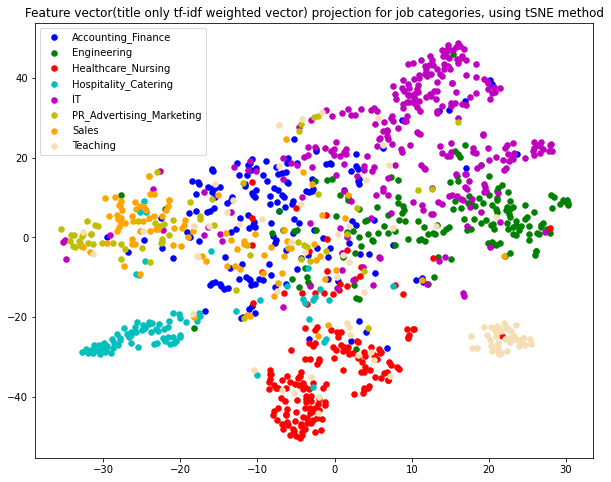

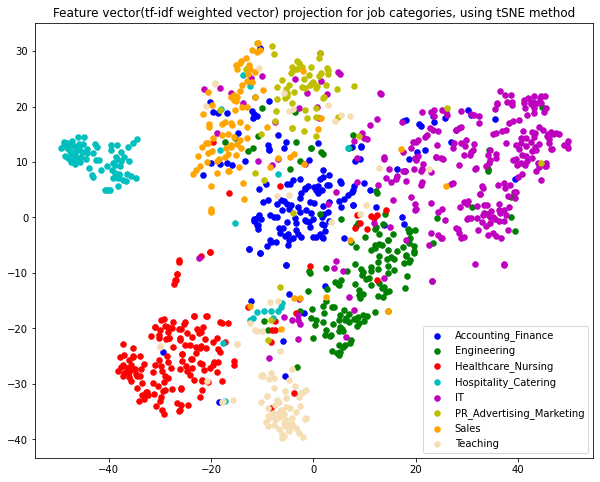

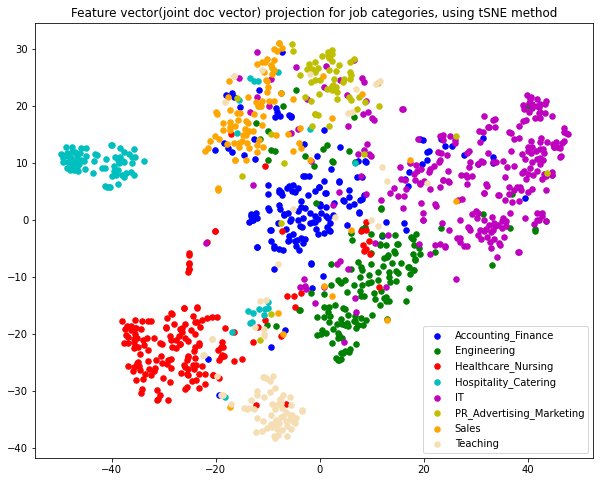

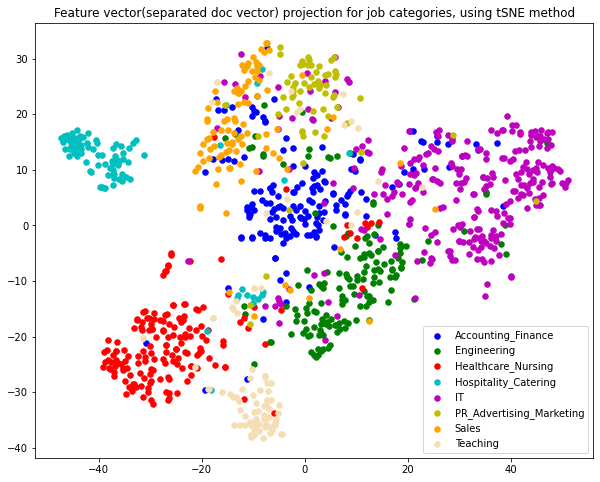

In [63]:
# Plot tSNE using feature vector acquired above

for key,doc_vec in doc_vector_list_Q2.items():
    plot_tSNE(label, doc_vec, 0.02, key)

#### Classification Model

In [17]:
# initialize a model
model = LogisticRegression(max_iter = 3000,random_state=2)

In [65]:
title_only_cv_result = cross_val_score(model, title_only_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using title only vector training finished, Average Accuray is ' + str(title_only_cv_result.mean()))

des_only_cv_result = cross_val_score(model, tfidfweighted_ft_doc_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using description only vector training finished, Average Accuray is ' + str(des_only_cv_result.mean()))

joint_cv_result = cross_val_score(model, title_des_vector, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using joint doc vector training finished, Average Accuray is ' + str(joint_cv_result.mean()))

seperate_cv_result = cross_val_score(model, concat_doc_vec, label, cv=5,verbose=2)
print("------------------------------------------------------------------------------------------------------")
print('Model using separated doc vector training finished, Average Accuray is ' + str(seperate_cv_result.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  34.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.2s remaining:    0.0s


[CV] END .................................................... total time=  36.5s
[CV] END .................................................... total time=  41.5s
[CV] END .................................................... total time=  37.9s
[CV] END .................................................... total time=  47.3s
------------------------------------------------------------------------------------------------------
Model using title only vector training finished, Average Accuray is 0.7807535392184279


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] END .................................................... total time=  59.4s
[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time=  54.9s
------------------------------------------------------------------------------------------------------
Model using description only vector training finished, Average Accuray is 0.8732168573622012


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END .................................................... total time= 1.0min
[CV] END .................................................... total time=  56.7s
[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time= 1.0min
------------------------------------------------------------------------------------------------------
Model using joint doc vector training finished, Average Accuray is 0.8776894478081715


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s


[CV] END .................................................... total time= 3.5min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 2.8min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 2.5min


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .................................................... total time= 2.6min
[CV] END .................................................... total time= 2.5min
------------------------------------------------------------------------------------------------------
Model using separated doc vector training finished, Average Accuray is 0.8779419080037805


C:\Users\Hongjie Xu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.9min finished


##### Q2 Experiment Results
| Feature vector | Cross-valid Accuracy Rate |
|---|---|
| Title only vector| 78.0753% |
| Description only vector | 87.3216% |
| Joint doc vector | 87.7689% |
| Separated doc vector | 87.7942% |


From above experiment result, it can be concluded that more information can provide more accuracy. However, it depends on the quality of information. 

    - Title only vector can achieve 78.0681%
    - Description only vector can achieve 87.3632%
    - Using both, not matter jointly training or separately training, can achieve almost 88%. 
    
Only using title has the worst performance. Adding title into data can only slightly improve the performance. 

More information may improve the model performance while it hard to say whether the improvement is significant or not.

## Summary

Task 2&3 mainly focus on training different word embeddings with different methods, including BOW count based, pretrained model based, and also TF-IDF weighted considered. 

Then, the job category classification model can be built on those acquired document vectors. Cross-validation is employed to better compare the classification performan among different document representations. 

In Question 1, it can be found that all seven feature representations show good performance on job classification. **Count Vector** and **TF-IDF Weighted FastText Vector** both achieve smilar highest perfromance, while others just slightly lower. Also, from the 2-dimension projection plots, the classification performed well on all feature representations. 

In Question 2, only using title as input information to generate the corresponding document vector still have 78% accuracy rate in classification task, while joint title&description document vector shows the highest accraucy rate, %87.84. 
It also can be concluded that jointly training or separately training has no significant difference on performance. 

From Q2, we can find the performance is mainly determined by how much information can be acquired from data. Title has less numbers of word, compared with description. It might the reason the model training only use title vector has lower accuracy rate, which is lower than 80%. On the other hand, the document vector generated from both title and description could achieve over 87.84% , which proves more information given can provide higher accuracy.